In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils import double_division_tracks, curated_tracks, DATA_ROOT

import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')
import seaborn as sns

from notebook_functions import timelapse_double_frame_sync

log_const = 300

## Spatial-time correlation

In [3]:
df_intensities = pd.read_csv(DATA_ROOT / 'intensities.csv', header=[0, 1, 2])
tracks = [int(x) for x in df_intensities.columns.unique(level=0) if x.isnumeric()]
frames = df_intensities.loc[:, ('frame_num', 'nan', 'nan')].values

In [40]:
sp = []
tm = []
for frame in frames[:5]:
    df_frm = df_intensities.loc[df_intensities[('frame_num', 'nan', 'nan')] == frame, (map(str, tracks), ('time', 'x', 'y'))].dropna(1)
    df_frm.columns = df_frm.columns.droplevel(2)
    df_frm = df_frm.stack(level=0)
    
    time = df_frm['time'].values
    xy = df_frm[['x', 'y']].values

    tm_dist = np.abs(time - time[..., np.newaxis])
    x2 = np.sum(xy * xy, 1, keepdims=True)
    sp_dist = np.sqrt(x2 + x2.T - 2 * np.dot(xy, xy.T))
    
    sp.extend(sp_dist[np.tril_indices(len(sp_dist), k=-1)])
    tm.extend(tm_dist[np.tril_indices(len(tm_dist), k=-1)])

sp = np.array(sp)
tm = np.array(tm) * 10 / 60

tm[tm > (33.0 / 2)] = 33.0 - tm[tm > (33.0 / 2)]

In [39]:
tm.max()

33.0

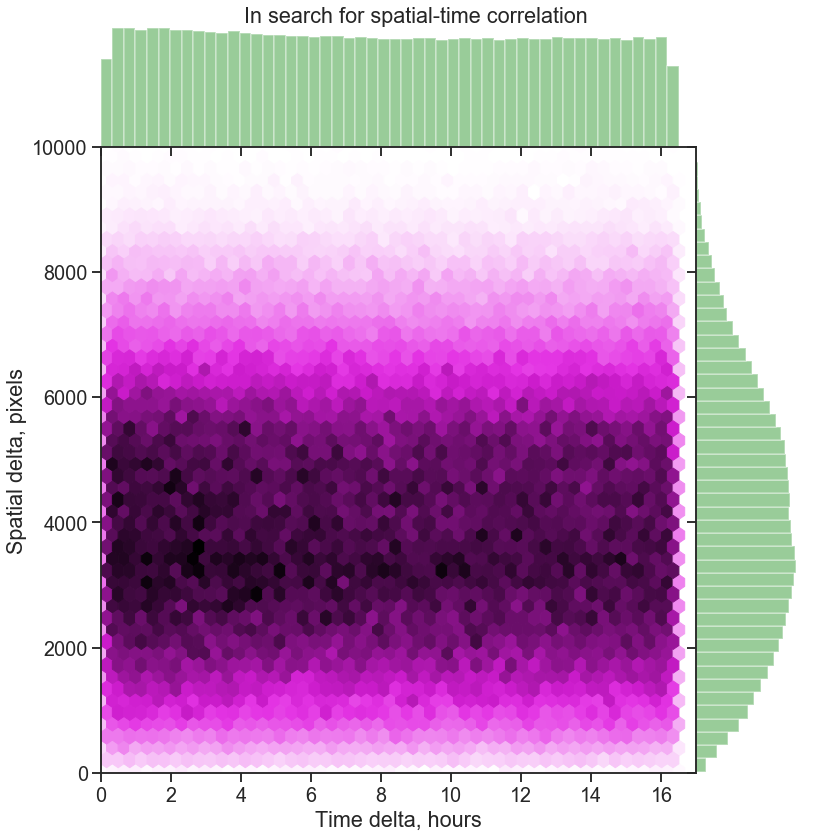

In [42]:
sns.set(style='ticks', color_codes=True)
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3.0})

g = sns.jointplot(x='Time delta, hours', y='Spatial delta, pixels',
                  data=pd.DataFrame(data={'Time delta, hours': tm, 'Spatial delta, pixels': sp}),
                  xlim=(0, 17),
                  ylim=(0, 10000),
                  color="violet",
                  space=0,
                  kind="hex",
                  height=12,
                  ratio=5,
                  joint_kws={"gridsize": 50},
                  marginal_kws={'color': 'green'})
_ = g.fig.suptitle('In search for spatial-time correlation')

In [ ]:
def undersample(x, bins, samples_per_bin):
    indices = np.digitize(x, bins=bins, right=False)
    idx = np.sort(np.unique(indices))[0: -1]
    ix = []
    for i in idx:
        ix.append(np.where(indices == i)[0][:samples_per_bin])
    ret_idx = np.zeros_like(x, dtype=bool)
    ret_idx[np.concatenate(ix)] = True
    return ret_idx

bins = np.arange(0, 200, 1)
samples_per_bin = 100
idx1 = undersample(tm, bins, samples_per_bin)

bins = np.arange(0, 8000, 100)
samples_per_bin = 100
idx2 = undersample(sp, bins, samples_per_bin)

idx = np.logical_and(idx1, idx2)
tm_undersampled = tm[idx]
sp_undersampled = sp[idx]

print(sum(idx1), sum(idx2), sum(idx))

In [ ]:
sns.set(style='ticks', color_codes=True)
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3.0})

g = sns.jointplot(x='Time delta, hours', y="Spatial delta, pixels",
                  data=pd.DataFrame(data={'Time delta, hours': tm_undersampled * 10 / 60, 'Spatial delta, pixels': sp_undersampled}),
                  xlim=(0, 27), 
                  ylim=(0, 9000),
                  color="violet",
                  space=0,
                  kind="hex",
                  height=12,
                  ratio=5,
                  joint_kws={"gridsize": 50},
                  marginal_kws={'color': 'green'})
_ = g.fig.suptitle('In search for spatial-time correlation')

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


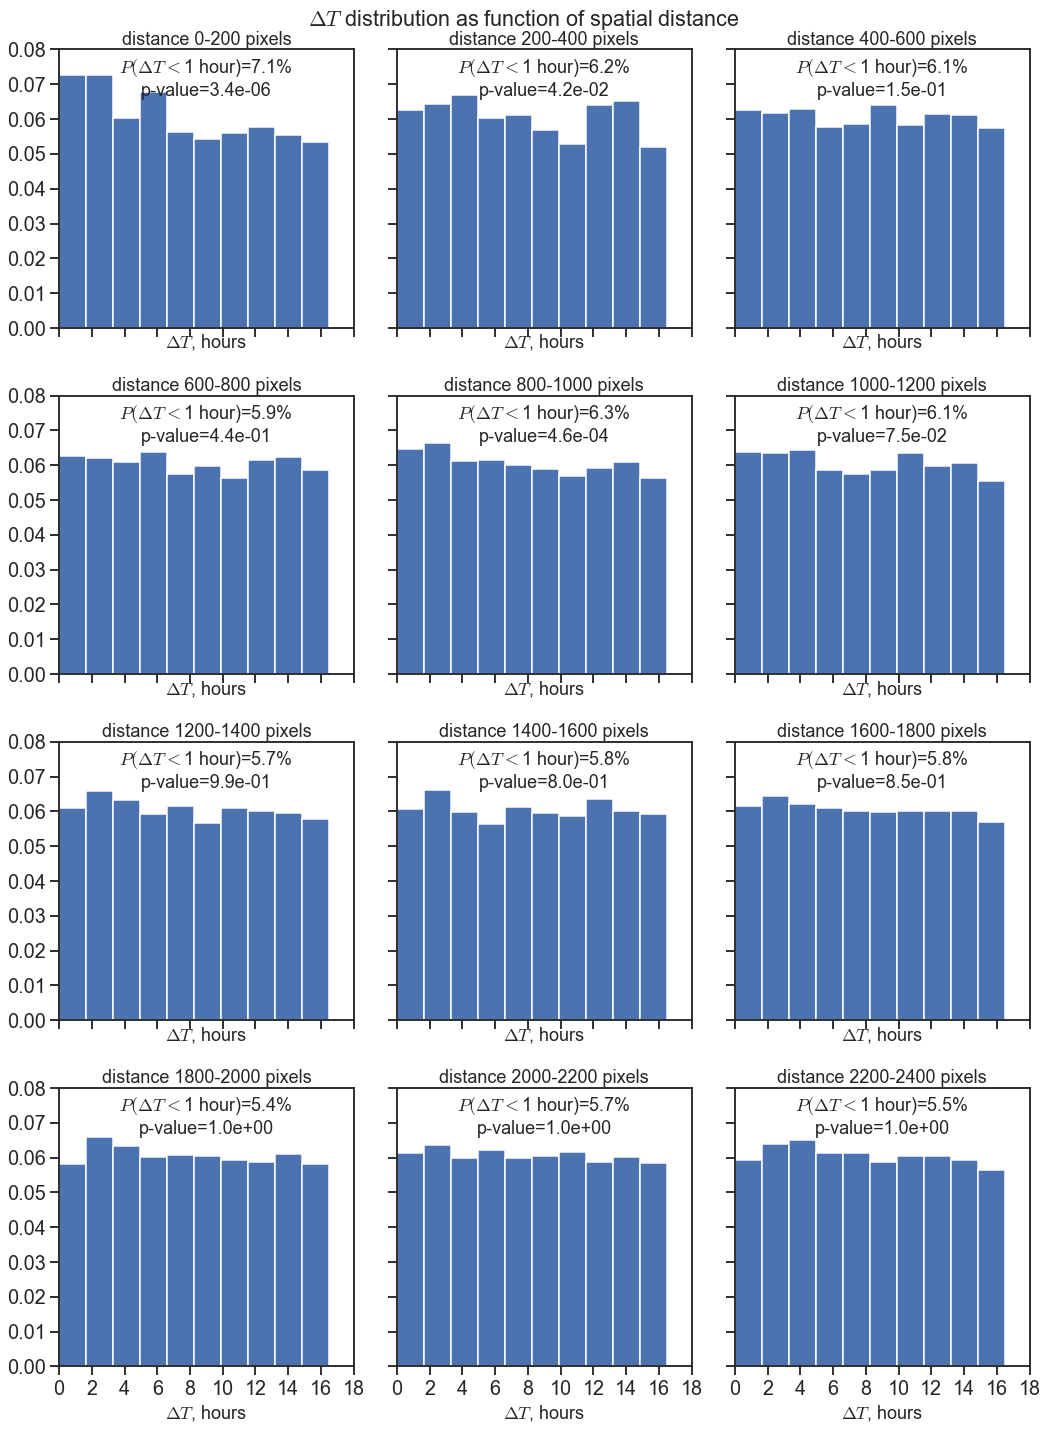

In [43]:
width = 200
steps = np.arange(0, 2400, width)
min_hours = 1
n_cols = 3
n_rows = int(np.ceil(len(steps) / n_cols))
fontsize = 18
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True,
                        tight_layout=True)
for i, step in enumerate(steps):
    ax = axs[i // n_cols, i % n_cols]
    band = (step, step + width)
    idx = np.logical_and(band[0] <= sp, sp < band[1])
    data = tm[idx]
    prob = (data < min_hours).sum() / len(data)
    
    count = [sum(data < min_hours), sum(tm < min_hours)]
    nobs = [len(data), len(tm)]
    stat, pval = proportions_ztest(count, nobs, alternative='larger')
    
    ax.hist(data, density=True)
    ax.set_title(f'distance {band[0]}-{band[1]} pixels', fontsize=fontsize)
    ax.set_xlabel(r'$\Delta T$, hours', fontsize=fontsize)
    ax.text(s=r'$P(\Delta T<$' + f'{min_hours} hour)={prob * 100:0.1f}%\np-value={pval:0.1e}', x=0.5, y=0.9, horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

_ = plt.suptitle(r'$\Delta T$ distribution as function of spatial distance', y=1.0)

In [5]:
frames_subset = list(range(0, 200, 1))
sp = []
tm = []
tm1 = []
max_num = None
sp_max = 200

for frame in frames[frames_subset]:
    df_frm = df_intensities.loc[df_intensities[('frame_num', 'nan', 'nan')] == frame, (map(str, tracks), ('time', 'x', 'y'))].dropna(1)
    df_frm.columns = df_frm.columns.droplevel(2)
    df_frm = df_frm.stack(level=0)
    
    i = np.random.choice(range(len(df_frm)), len(df_frm) if max_num is None else max_num, replace=False)
    time = df_frm['time'].values[i]
    xy = df_frm[['x', 'y']].values[i]

    tm_dist = np.abs(time - time[..., np.newaxis])
    x2 = np.sum(xy * xy, 1, keepdims=True)
    sp_dist = np.sqrt(x2 + x2.T - 2 * np.dot(xy, xy.T))
    
    idx = np.where(~np.eye(tm_dist.shape[0], dtype=bool))
    
    sp_dist = sp_dist[idx]
    tm_dist = tm_dist[idx]
    tm1_ = np.repeat(time[..., np.newaxis], time.shape[0], axis=1)[idx]
    
    sp_filter = sp_dist <= sp_max
    sp.extend(sp_dist[sp_filter])
    tm.extend(tm_dist[sp_filter])
    tm1.extend(tm1_[sp_filter])

sp = np.array(sp)
tm = np.array(tm) * 10 / 60
tm1 = np.array(tm1) * 10 / 60

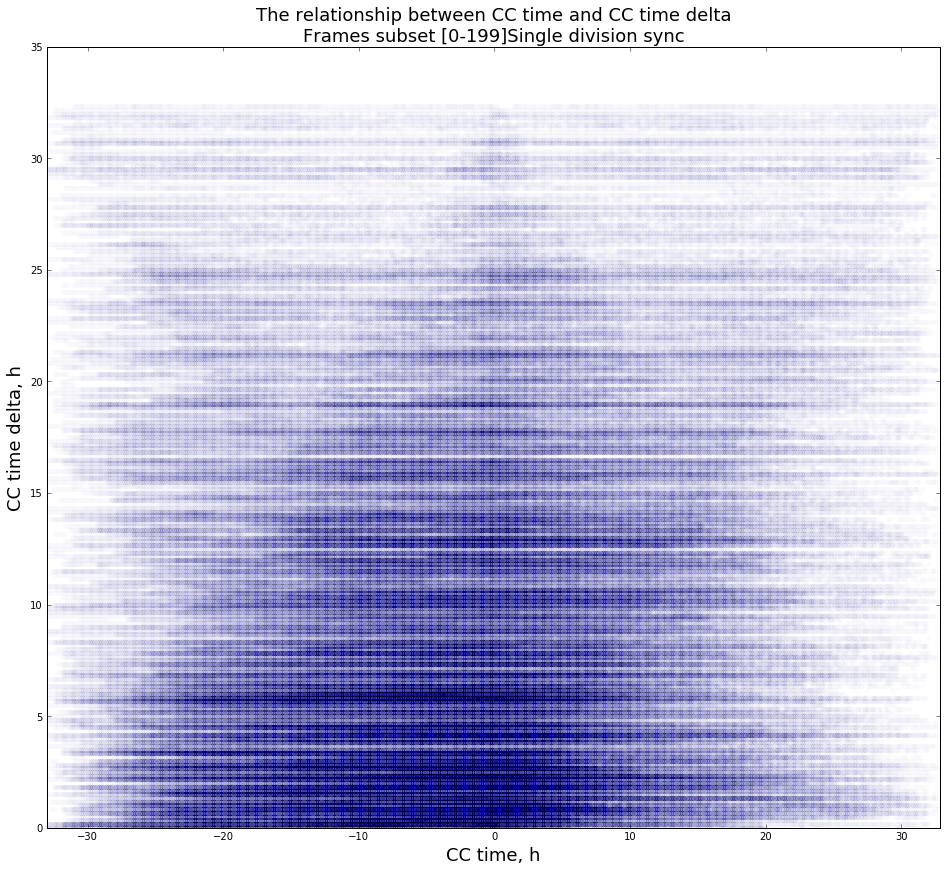

In [6]:
step = 1
fontsize = 18
plt.figure(figsize=(16, 14))
plt.scatter(tm1[::step], tm[::step], alpha=0.01)
plt.ylim((0, 35))
plt.xlim((tm1[::step].min(), tm1[::step].max()))
plt.xlabel('CC time, h', fontsize=fontsize)
plt.ylabel('CC time delta, h', fontsize=fontsize)
_ = plt.title(f'The relationship between CC time and CC time delta\nFrames subset [{frames_subset[0]}-{frames_subset[-1]}]'
'Single division sync', fontsize=fontsize)

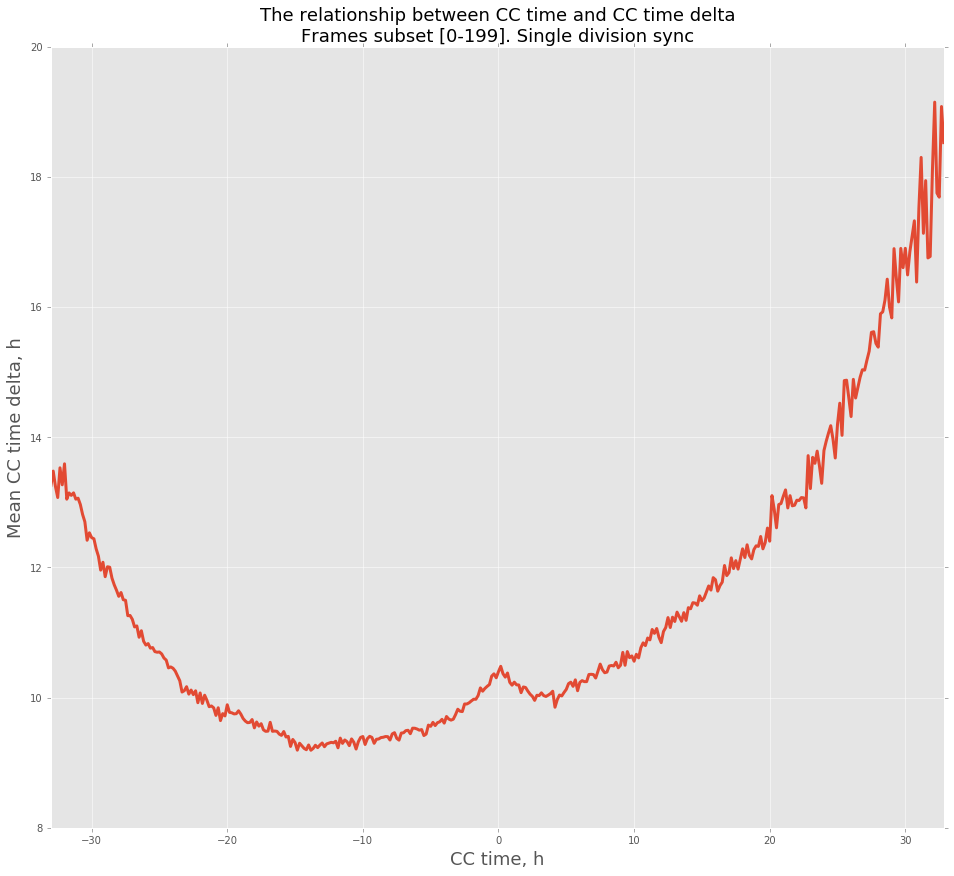

In [32]:
fun = np.mean
tm1_index = np.sort(np.unique(tm1))
tm_average = []
for t in tm1_index:
    tm_average.append(fun(tm[tm1 == t]))
tm_average = np.array(tm_average)

fontsize = 18
plt.figure(figsize=(16, 14))
plt.style.use('ggplot')

plt.plot(tm1_index, tm_average, linewidth=3)
plt.xlim((tm1_index.min(), tm1_index.max()))
plt.xlabel('CC time, h', fontsize=fontsize)
plt.ylabel(f'{fun.__name__.capitalize()} CC time delta, h', fontsize=fontsize)
_ = plt.title(f'The relationship between CC time and CC time delta\nFrames subset [{frames_subset[0]}-{frames_subset[-1]}]. ' 
'Single division sync', fontsize=fontsize)

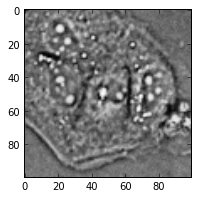

In [8]:
channel = 'BF'
BF_ROOT = DATA_ROOT / channel
frame = 0
pos = 0
sz = 100
sz2 = sz // 2
lower_percentile = 0
upper_percentile = 100

def img16to8bit(img, lower_percentile, upper_percentile):
    lower_bound, upper_bound = np.percentile(img, lower_percentile), np.percentile(img, upper_percentile)
    img = (img - lower_bound) / (upper_bound - lower_bound) * 255
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    img = clahe.apply(img)
    return img
    
    
def crop_patch(img, x, y, lower_percentile=0, upper_percentile=100, sz2=40, normalize_patch=True):
    patch = img[y - sz2: y + sz2, x - sz2: x + sz2]
    if normalize_patch:
        patch = img16to8bit(patch, lower_percentile=lower_percentile, upper_percentile=upper_percentile)
    return patch


df_frm = df_intensities.loc[df_intensities[('frame_num', 'nan', 'nan')] == frame, (map(str, tracks), ('time', 'x', 'y'))].dropna(1)
df_frm.columns = df_frm.columns.droplevel(2)
df_frm = df_frm.stack(level=0)
xy = df_frm[['x', 'y']].values

frame_name = BF_ROOT / f'T{frame + 1:03d}'
img = cv2.imread(str(frame_name), cv2.CV_16U)

x, y = xy[pos].astype(int)
patch = crop_patch(img, x, y, sz2=sz2, lower_percentile=lower_percentile, upper_percentile=upper_percentile, normalize_patch=True)

plt.figure(figsize=(3, 3))
plt.imshow(patch, cmap='Greys_r')

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


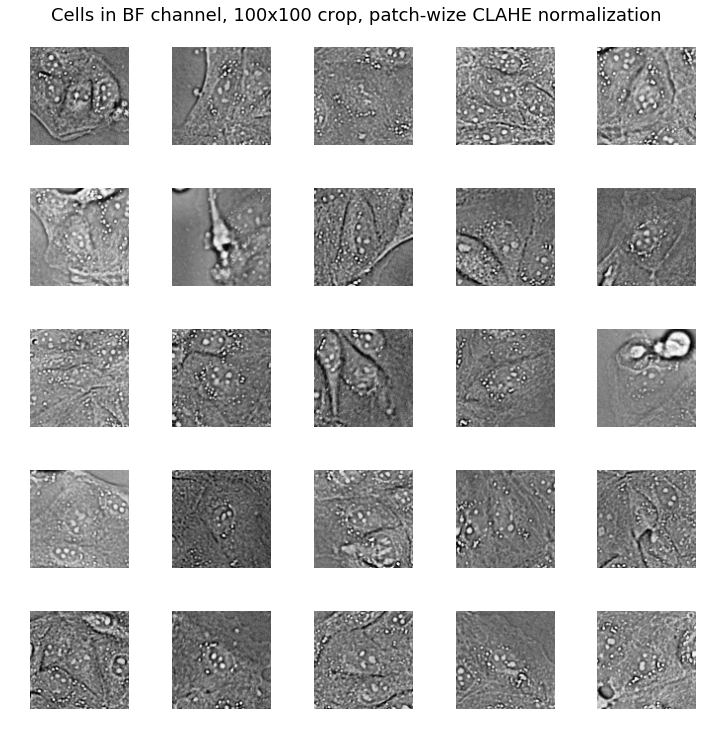

In [9]:
fontsize = 18
n_rows = 5
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), sharex='none', sharey='none', tight_layout=True)
for i, step in enumerate(range(n_rows * n_cols)):
    ax = axs[i // n_cols, i % n_cols]
    x, y = xy[i].astype(int)
    patch = crop_patch(img, x, y, sz2=sz2, lower_percentile=lower_percentile, upper_percentile=upper_percentile, normalize_patch=True)
    
    ax.imshow(patch, cmap='Greys_r')
    ax.axis('off')
    
_ = plt.suptitle(f'Cells in {channel} channel, {sz}x{sz} crop, patch-wize CLAHE normalization', fontsize=fontsize, y=1.02)

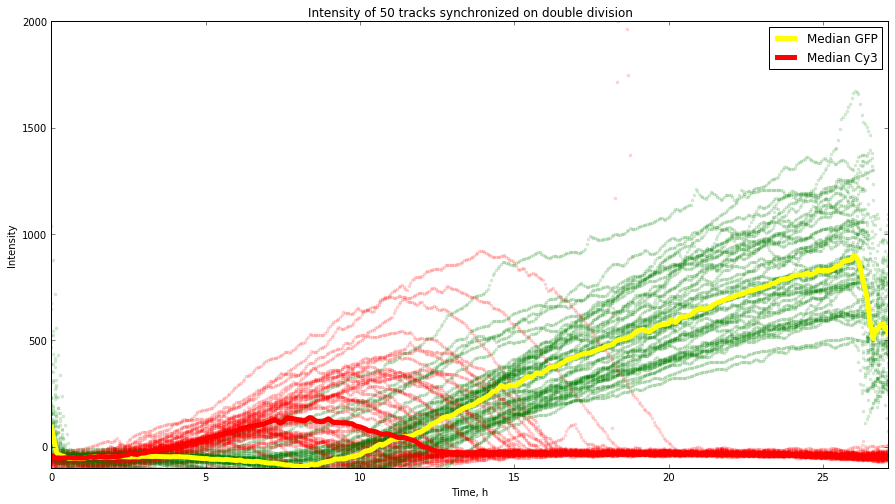

In [25]:
nnods = 500
gr_median, _, gr = timelapse_double_frame_sync(df_intensities, double_division_tracks, nnods=nnods)
g, r = gr
g_median = gr_median[:, 0]
r_median = gr_median[:, 1]

dd_frames = np.array(list(double_division_tracks.values()))
average_track_duration = np.mean(dd_frames[:, 1] - dd_frames[:, 0]) * 10 / 60  # hours

min_time = 0
max_time = average_track_duration

0
0.0 25295 29
0.0 448 33
0.0 3890 21
0.0 18367 14
0.0 27592 43
56
3.0 10455 28
3.0 8117 20
3.0 1735 30
3.0 2660 24
3.0 6950 20
111
6.0 10455 48
6.0 2660 41
6.0 25101 61
6.0 17953 53
6.0 1735 51
166
9.0 10455 68
9.0 6240 60
9.0 6382 60
9.0 25313 84
9.0 2340 99
221
12.0 1735 93
12.0 2151 86
12.0 6240 77
12.0 25843 97
12.0 7143 83
276
15.0 14298 103
15.0 2340 128
15.0 1735 113
15.0 15006 102
15.0 6240 94
332
18.0 7143 123
18.0 2340 143
18.0 1735 134
18.0 18369 131
18.0 6427 129
387
21.0 6427 150
21.0 15006 139
21.0 18328 135
21.0 7143 143
21.0 2974 141
442
24.0 6240 146
24.0 2974 162
24.0 18328 152
24.0 2920 171
24.0 25843 162
497
27.0 6950 176
27.0 14298 178
27.0 4137 185
27.0 8117 175
27.0 25101 183


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


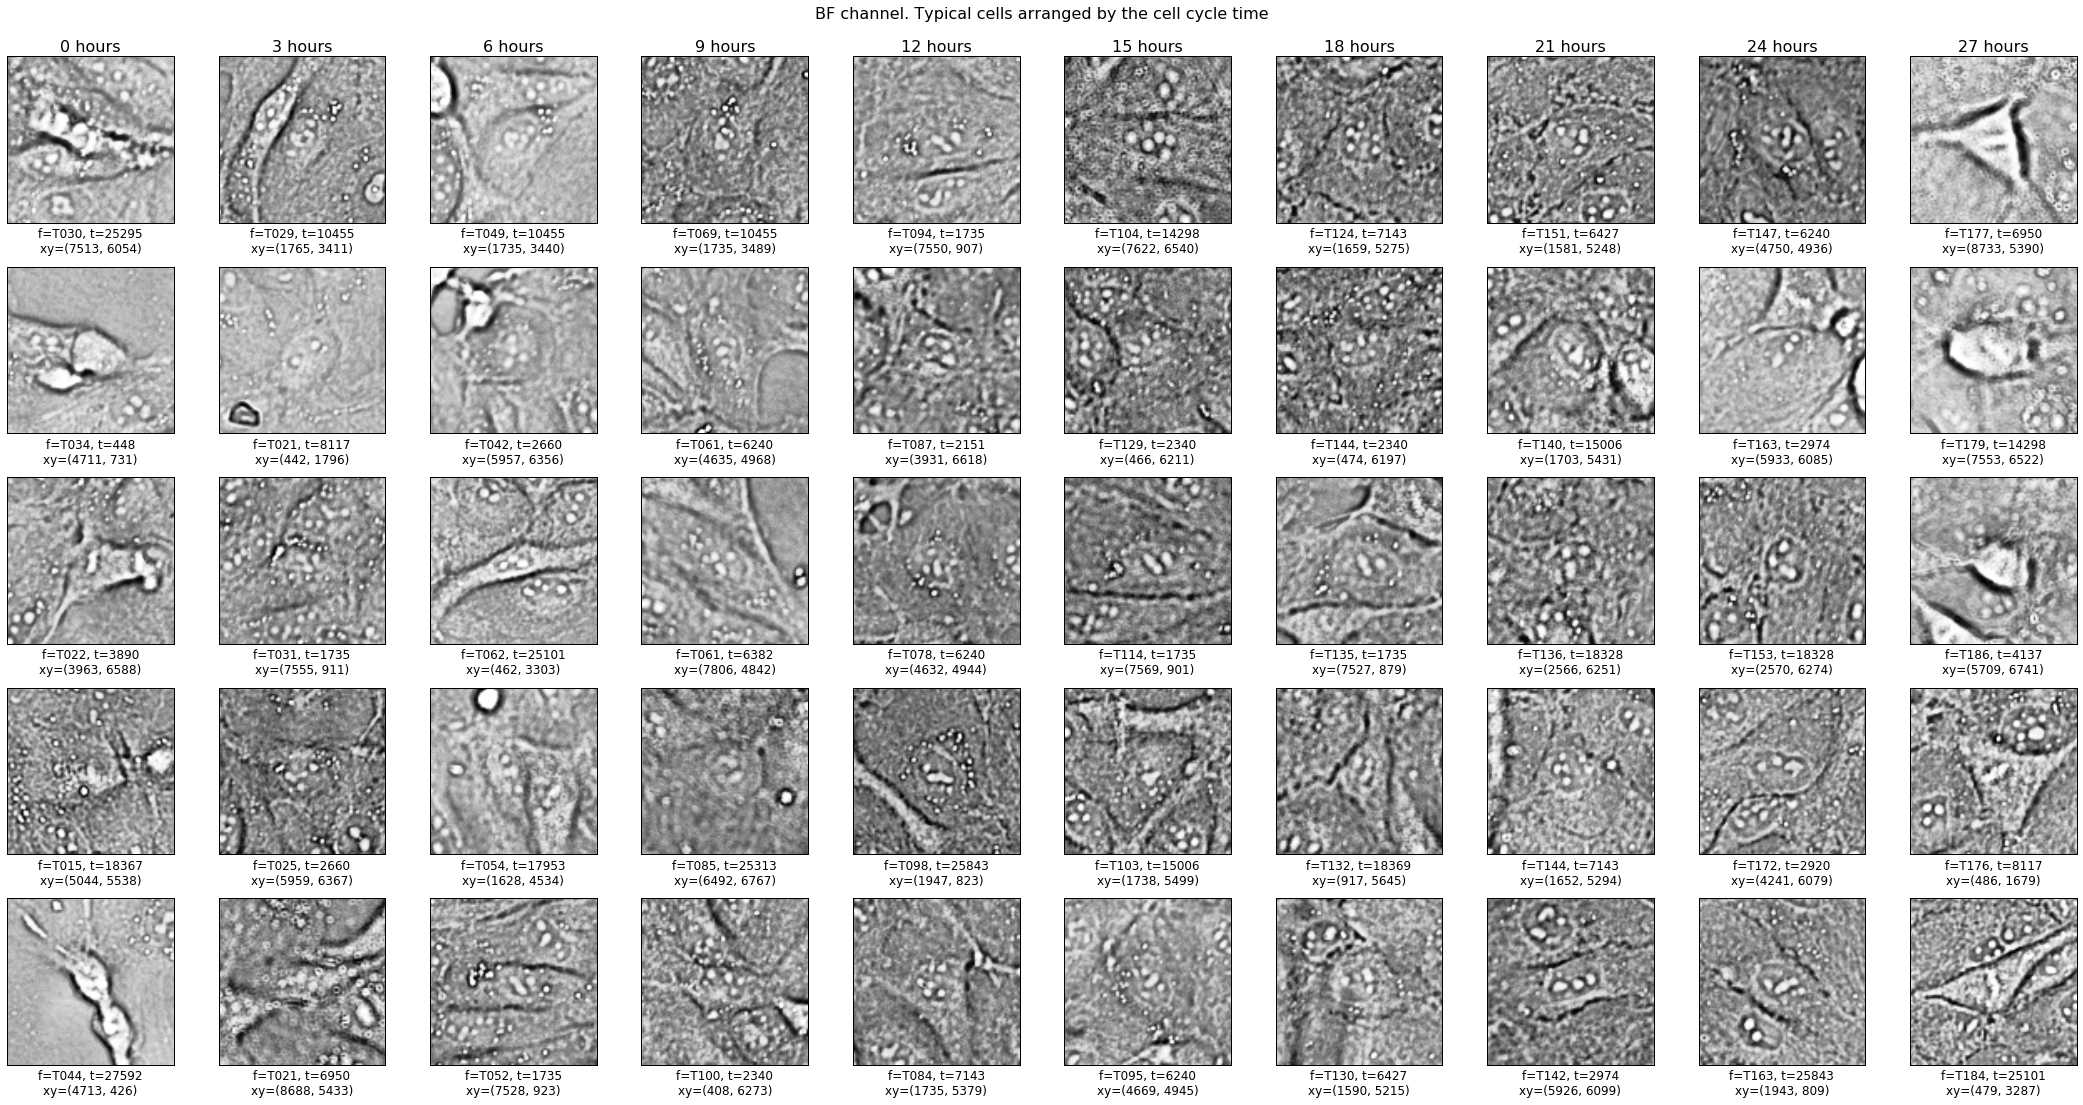

In [46]:
channel = 'BF'
CHANNEL_ROOT = DATA_ROOT / channel
sz = 100
sz2 = sz // 2
lower_percentile = 0
upper_percentile = 100
fontsize = 16
fontsize_small = 12
n_rows = 5

sq_tracks = np.square(np.log(g + log_const)) + np.square(np.log(r + log_const))
sq_median = np.square(np.log(g_median + log_const)) + np.square(np.log(r_median + log_const))
close_to_med_tracks = np.argsort(np.abs(sq_tracks - sq_median), axis=0)

joint_time = np.linspace(min_time, max_time, nnods)
time_bins = np.arange(0, max_time, 1)
time_bins = np.arange(0, max_time, 3)
# time_bins = time_bins[:3]
n_cols = len(time_bins)
joint_time_binned = np.digitize(joint_time, time_bins) - 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows), sharex='none', sharey='none', tight_layout=True)

for t, time_bin in enumerate(time_bins):
    idx = np.where(joint_time_binned == t)[0][0]
    tracks_to_plot = [sorted(double_division_tracks)[i] for i in close_to_med_tracks[:n_rows, idx]]
    print(idx)

    for row, track in enumerate(tracks_to_plot):
        start, stop = double_division_tracks[track]
        track_time = np.linspace(min_time, max_time, stop - start + 1)
        track_time_binned = np.digitize(track_time, time_bins) - 1

        frame = np.where(track_time_binned == t)[0][0] + start
        print(time_bin, track, frame)
        
        ax = axs[row, t]
        frame_name = f'T{frame + 1:03d}'
        img = cv2.imread(str(CHANNEL_ROOT / frame_name), cv2.CV_16U)
        x, y = df_intensities.loc[df_intensities[('frame_num', 'nan', 'nan')] == frame, (str(track), ['x', 'y'])].astype(int).values[0]
        patch = crop_patch(img, x, y, sz2=sz2, lower_percentile=lower_percentile, upper_percentile=upper_percentile, normalize_patch=True)
        ax.imshow(patch, cmap='Greys_r')
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        ax.set_xlabel(f'f={frame_name}, t={track}\nxy=({x}, {y})', fontsize=fontsize_small)
        if row == 0:
            ax.set_title(f'{int(time_bin)} hours', fontsize=fontsize)
_ = plt.suptitle(f'{channel} channel. Typical cells arranged by the cell cycle time', fontsize=fontsize, y=1.02)